# Avaliação – Produto Renda Fixa
## Construção de uma calculadora de renda fixa em Python - NTN-F


Formato de envio: arquivo .ipynb (Jupyter Notebook) conforme instruções a seguir.


### Funções/métodos mínimos de entrega:
- calcula_prazo(dt_ini, dt_fim, feriados, convencao)
    - Retorna: prazo anualizado (float)
    - convencao: 'DU/252' ou 'DC/360'
    
    
- constroi_fluxo(dt_fim, frequencia)
    - Retorna: Lista de datas dos fluxos (list datetime.date)
    
    
- calcula_pu(VF, prazo_anual, taxa_anual)
    - Retorna pu (float)
    
    
- calcula_taxa_anual(PU, prazo_anual, valor_base=100)
    - Retorna: taxa_anual (float)
    
    
- calcula_pu_ntnf(dt_venc, dt_base, tir) *
    - Retorna: pu (float)
    - Imprime tabela com o cashflow (Data do fluxo, VF, DU, Fator de desconto, PU)

# Desenvolvimento do projeto

In [1]:
import pandas as pd
import datetime as dt
import locale
from dateutil.relativedelta import relativedelta

## 1. Análise de consistência dos dados
Verificando o calendário de feriados nacionais da ANBIMA

In [2]:
# Criando um dataframe para ler o arquivo do calendário de feriados da ANBIMA
df_feriados = pd.read_excel('https://www.anbima.com.br/feriados/arqs/feriados_nacionais.xls')

# Removendo as colunas desnecessárias para ficar apenas com as datas
feriados = df_feriados.copy()
feriados.drop(['Dia da Semana', 'Feriado'], axis=1, inplace=True)

In [3]:
# Verificando o tamanho da base de dados
feriados.shape

(945, 1)

In [4]:
# Verificando a quantidade de dados válidos
feriados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 945 entries, 0 to 944
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Data    941 non-null    object
dtypes: object(1)
memory usage: 7.5+ KB


In [5]:
# Verificando os dados nulos
feriados[feriados['Data'].isna()]

,Data
937,NaN
939,NaN
941,NaN
943,NaN


In [6]:
# Verificando os últimos registros da base de dados, já que os dados nulos aparecem no final
feriados.tail(10)

,Data
935,2078-12-25 00:00:00
936,Fonte: ANBIMA
937,NaN
938,"1) De acordo com a Resolução n º 2.516, a part..."
939,NaN
940,"2) A lei nº 9.504/97 estabeleceu que, em ano e..."
941,NaN
942,"3) De acordo com a Resolução nº 2.596/99, no ú..."
943,NaN
944,4) Esta listagem não inclui os feriados munici...


In [7]:
# Convertendo os dados para datetime e criando dados nulos em caso de erro
feriados['Data'] = pd.to_datetime(feriados['Data'], errors='coerce')

In [8]:
# Verificando o tipo dos dados
feriados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 945 entries, 0 to 944
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Data    936 non-null    datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 7.5 KB


In [9]:
# Verificando os últimos registros
feriados.tail(10)

,Data
935,2078-12-25
936,NaT
937,NaT
938,NaT
939,NaT
940,NaT
941,NaT
942,NaT
943,NaT
944,NaT


In [10]:
# Removendo os dados nulos
feriados = feriados.drop(feriados[feriados['Data'].isna()].index)

In [11]:
# Verificando novamente os últimos registros
feriados.tail()

,Data
931,2078-09-07
932,2078-10-12
933,2078-11-02
934,2078-11-15
935,2078-12-25


In [12]:
feriados.head()

,Data
0,2001-01-01
1,2001-02-26
2,2001-02-27
3,2001-04-13
4,2001-04-21


## 2. Análise Exploratória dos Dados

Criando um calendário com data inicial e final estabelecidas para verificar se os dados estão corretos.

In [13]:
# Escolhendo o ano de 2028 que, além de ser bissexto, um dos feriados cai no dia 29/02.
dt_ini = '01/01/2028'
dt_fim = '31/12/2028'

# Convertendo as datas para datetime e depois date
dt_ini = dt.datetime.strptime(dt_ini, "%d/%m/%Y").date()
dt_fim = dt.datetime.strptime(dt_fim, "%d/%m/%Y").date()  

print(dt_ini)
print(dt_fim)

2028-01-01
2028-12-31


In [14]:
# Definindo o local, apenas para os dias da semana aparecerem em português
try:
    locale.setlocale(locale.LC_ALL, 'pt_BR')
except:
    locale.setlocale(locale.LC_ALL, 'Portuguese_Brazil')

# Criando um DF para visualizar as datas e dias da semana
df_dias_corridos = pd.DataFrame({'Data': pd.date_range(dt_ini, dt_fim)})
df_dias_corridos['Dia da semana'] = df_dias_corridos['Data'].dt.strftime('%A')

In [15]:
df_dias_corridos.head()

,Data,Dia da semana
0,2028-01-01,sábado
1,2028-01-02,domingo
2,2028-01-03,segunda-feira
3,2028-01-04,terça-feira
4,2028-01-05,quarta-feira


In [16]:
# Verificando se o dia da semana bate com o calendário
dt_ini.weekday()

5

In [17]:
# Verificando se 2028 bate com o ano bissexto
len(df_dias_corridos)

366

In [18]:
# Criando um filtro para selecionar os feriados, de acordo com as datas inicial e final estabelecidas
filtro_feriados = [feriado.date() for feriado in feriados['Data'] if dt_ini <= feriado <= dt_fim]

In [19]:
filtro_feriados

[datetime.date(2028, 1, 1),
 datetime.date(2028, 2, 28),
 datetime.date(2028, 2, 29),
 datetime.date(2028, 4, 14),
 datetime.date(2028, 4, 21),
 datetime.date(2028, 5, 1),
 datetime.date(2028, 6, 15),
 datetime.date(2028, 9, 7),
 datetime.date(2028, 10, 12),
 datetime.date(2028, 11, 2),
 datetime.date(2028, 11, 15),
 datetime.date(2028, 12, 25)]

In [20]:
len(filtro_feriados)

12

In [21]:
# Definindo outras datas para ver se a quantidade de dias úteis/corridos está de acordo com o site do Tesouro Direto
dt_ini = dt.date.today()
dt_fim = '01/01/2031'
dt_fim = dt.datetime.strptime(dt_fim, "%d/%m/%Y").date()

dt_ini += dt.timedelta(days=1) # Liquidação = D+1

filtro_feriados = [feriado.date() for feriado in feriados['Data'] if dt_ini <= feriado <= dt_fim]

while (dt_ini.weekday() > 4) or (dt_ini in filtro_feriados):
    dt_ini += dt.timedelta(days=1)
print(f'Data de liquidação: {dt_ini}')

# Quantidade de dias corridos
dias_corridos = (dt_fim-dt_ini).days

# Quantidade de dias úteis
while (dt_fim.weekday() > 4) or (dt_fim in filtro_feriados):
    dt_fim += dt.timedelta(days=1)
    
data_atual = dt_ini
dias_uteis = 0
while data_atual <= dt_fim:
    data_atual += dt.timedelta(days=1)
    if data_atual > dt_fim:
        break
    if (data_atual in filtro_feriados) or (data_atual.weekday() > 4):
        continue
    else:
        dias_uteis += 1
        
print(f'Data do vencimento em dia útil: {dt_fim}') 
print(f'Dias corridos: {dias_corridos}')
print(f'Dias úteis: {dias_uteis}')

Data de liquidação: 2022-02-21
Data do vencimento em dia útil: 2031-01-02
Dias corridos: 3236
Dias úteis: 2225


## 3. Calculadora de renda fixa em Python - NTN-F

Serão realizados dois testes neste projeto:   
    - Teste 1: NTN-F de 20/05/2008 (data de compra) a 01/01/2014, com TIR = 13,66%;   
    - Teste 2: NTN-F de 18/02/2022 (data de compra) a 01/01/2031, com TIR = 11,48%.

### 3.1 Prazo

### 3.1.1 Prazo anualizado

In [22]:
def calcula_prazo(dt_ini, dt_fim, feriados, convencao):
    
    # Convertendo as datas de string para date
    dt_ini = dt.datetime.strptime(dt_ini, "%d/%m/%Y").date()
    dt_fim = dt.datetime.strptime(dt_fim, "%d/%m/%Y").date()
    
    # Data de liquidação (D+1)
    dt_ini += dt.timedelta(days=1)
    
    # Removendo as colunas desnecessárias em "df_feriados" para ficar apenas com as datas
    df_feriados = feriados.copy()
    df_feriados.drop(['Dia da Semana', 'Feriado'], axis=1, inplace=True)

    # Convertendo os dados de "df_feriados" para datetime e criando dados nulos em caso de erro
    df_feriados['Data'] = pd.to_datetime(df_feriados['Data'], errors='coerce')
    
    # Removendo os dados nulos de "df_feriados"
    df_feriados = df_feriados.drop(df_feriados[df_feriados['Data'].isna()].index)
    
    # Criando um filtro para selecionar os feriados, de acordo com as datas inicial e final
    filtro_feriados = [feriado.date() for feriado in df_feriados['Data'] if dt_ini <= feriado <= dt_fim]

    # Data de liquidação em dia útil
    while (dt_ini.weekday() > 4) or (dt_ini in filtro_feriados):
        dt_ini += dt.timedelta(days=1)
        
    # Quantidade de dias corridos
    dias_corridos = (dt_fim-dt_ini).days

    # Quantidade de dias úteis
    while (dt_fim.weekday() > 4) or (dt_fim in filtro_feriados):
        dt_fim += dt.timedelta(days=1)

    data_atual = dt_ini
    dias_uteis = 0
    while data_atual <= dt_fim:
        data_atual += dt.timedelta(days=1)
        if data_atual > dt_fim:
            break
        if (data_atual in filtro_feriados) or (data_atual.weekday() > 4):
            continue
        else:
            dias_uteis += 1

    # Anualizando o prazo
    if convencao == 'DU/252':
        prazo_anualizado = round(dias_uteis/252, 14)
    elif convencao == 'DC/360':
        prazo_anualizado = round(dias_corridos/360, 14)
        
    return prazo_anualizado

In [23]:
# Definindo as datas e feriados para o "Teste 1"
dt_ini = '20/05/2008'
dt_fim = '01/01/2014'
feriados = pd.read_excel('https://www.anbima.com.br/feriados/arqs/feriados_nacionais.xls')

In [24]:
# Teste de prazo anualizado "DC/360"
convencao = 'DC/360'
resposta = calcula_prazo(dt_ini, dt_fim, feriados, convencao)
print(f'Prazo anualizado (dias corridos): {resposta}')

Prazo anualizado (dias corridos): 5.69722222222222


In [25]:
# Teste de prazo anualizado "DU/252"
convencao = 'DU/252'
resposta = calcula_prazo(dt_ini, dt_fim, feriados, convencao)
print(f'Prazo anualizado (dias úteis): {resposta}')

Prazo anualizado (dias úteis): 5.61507936507936


### 3.1.2 Prazo em dias

In [26]:
def calcula_prazo_dias(dt_ini, dt_fim, feriados, tipo):
    
    # Convertendo as datas de string para date
    dt_ini = dt.datetime.strptime(dt_ini, "%d/%m/%Y").date()
    dt_fim = dt.datetime.strptime(dt_fim, "%d/%m/%Y").date()
    
    # Data de liquidação (D+1)
    dt_ini += dt.timedelta(days=1)
    
    # Removendo as colunas desnecessárias em "df_feriados" para ficar apenas com as datas
    df_feriados = feriados.copy()
    df_feriados.drop(['Dia da Semana', 'Feriado'], axis=1, inplace=True)

    # Convertendo os dados de "df_feriados" para datetime e criando dados nulos em caso de erro
    df_feriados['Data'] = pd.to_datetime(df_feriados['Data'], errors='coerce')
    
    # Removendo os dados nulos de "df_feriados"
    df_feriados = df_feriados.drop(df_feriados[df_feriados['Data'].isna()].index)
    
    # Criando um filtro para selecionar os feriados, de acordo com as datas inicial e final
    filtro_feriados = [feriado.date() for feriado in df_feriados['Data'] if dt_ini <= feriado <= dt_fim]

    # Data de liquidação em dia útil
    while (dt_ini.weekday() > 4) or (dt_ini in filtro_feriados):
        dt_ini += dt.timedelta(days=1)
        
    # Quantidade de dias corridos
    dias_corridos = (dt_fim-dt_ini).days

    # Quantidade de dias úteis
    while (dt_fim.weekday() > 4) or (dt_fim in filtro_feriados):
        dt_fim += dt.timedelta(days=1)

    data_atual = dt_ini
    dias_uteis = 0
    while data_atual <= dt_fim:
        data_atual += dt.timedelta(days=1)
        if data_atual > dt_fim:
            break
        if (data_atual in filtro_feriados) or (data_atual.weekday() > 4):
            continue
        else:
            dias_uteis += 1

    # Verificando a convenção para dar o prazo em dias úteis ou corridos
    if tipo == 'DU':
        prazo_dias = dias_uteis
    elif tipo == 'DC':
        prazo_dias = dias_corridos
        
    return prazo_dias

In [27]:
# Teste de prazo em dias "DC"
tipo = 'DC'
resposta = calcula_prazo_dias(dt_ini, dt_fim, feriados, tipo)
print(f'Prazo em dias corridos: {resposta}')

Prazo em dias corridos: 2051


In [28]:
# Teste de prazo em dias "DU"
tipo = 'DU'
resposta = calcula_prazo_dias(dt_ini, dt_fim, feriados, tipo)
print(f'Prazo em dias úteis: {resposta}')

Prazo em dias úteis: 1415


### 3.2 Fluxo

In [29]:
def constroi_fluxo(dt_fim, frequencia):

    # Convertendo a data de string para date
    dt_fim = dt.datetime.strptime(dt_fim, "%d/%m/%Y").date()
    
    # Definindo a data de compra
    dt_hoje = '20/05/2008'
    dt_hoje = dt.datetime.strptime(dt_hoje, "%d/%m/%Y").date()
    
    # Criando um laço para pegar as datas de pagamento dos cupons, partindo de "dt_fim" até chegar em "dt_hoje"
    dt_subtrai_fim = dt_fim
    lista_de_datas_dos_fluxos = []
    
    if frequencia == 'anual':
        freq = relativedelta(years=+1)
    elif frequencia == 'semestral':
        freq = relativedelta(months=+6)
    elif frequencia == 'trimestral':
        freq = relativedelta(months=+3)
    elif frequencia == 'mensal':
        freq = relativedelta(months=+1)
    
    while dt_subtrai_fim > dt_hoje:
        lista_de_datas_dos_fluxos.append(dt_subtrai_fim)
        dt_subtrai_fim -= freq
        
    # Ordenando a lista com as datas dos fluxos
    lista_de_datas_dos_fluxos.sort()
    
    return lista_de_datas_dos_fluxos

In [30]:
# # Teste de fluxo com frequencia = 'anual'
# frequencia = 'anual'
# resposta = constroi_fluxo(dt_fim, frequencia)
# print('Datas dos fluxos com frequência anual:')
# resposta

In [31]:
# Teste de fluxo com frequencia = 'semestral'
frequencia = 'semestral'
resposta = constroi_fluxo(dt_fim, frequencia)
print('Datas dos fluxos com frequência semestral:')
resposta

Datas dos fluxos com frequência semestral:


[datetime.date(2008, 7, 1),
 datetime.date(2009, 1, 1),
 datetime.date(2009, 7, 1),
 datetime.date(2010, 1, 1),
 datetime.date(2010, 7, 1),
 datetime.date(2011, 1, 1),
 datetime.date(2011, 7, 1),
 datetime.date(2012, 1, 1),
 datetime.date(2012, 7, 1),
 datetime.date(2013, 1, 1),
 datetime.date(2013, 7, 1),
 datetime.date(2014, 1, 1)]

In [32]:
# # Teste de fluxo com frequencia = 'trimestral'
# frequencia = 'trimestral'
# resposta = constroi_fluxo(dt_fim, frequencia)
# print('Datas dos fluxos com frequência trimestral:')
# resposta

In [33]:
# # Teste de fluxo com frequencia = 'mensal'
# frequencia = 'mensal'
# resposta = constroi_fluxo(dt_fim, frequencia)
# print('Datas dos fluxos com frequência mensal:')
# resposta

### 3.3 Valor Futuro

In [34]:
def valor_futuro(taxa_anual, frequencia, VN, lista_fluxo):
    
    if frequencia == 'anual':
        freq = 1
    elif frequencia == 'semestral':
        freq = 1/2
    elif frequencia == 'trimestral':
        freq = 1/4
    elif frequencia == 'mensal':
        freq = 1/12
        
    cupom = round((1 + taxa_anual)**(freq) - 1, 8)    
    
    lista_VF = []
    for data_pagamento in lista_fluxo:            
        if data_pagamento < lista_fluxo[-1]:
            VF = round(VN * cupom, 5)
            lista_VF.append(VF)
        elif data_pagamento == lista_fluxo[-1]:
            VF = round(VN * (1 + cupom), 5)
            lista_VF.append(VF)
    
    return lista_VF

In [35]:
# Teste de VF
taxa_anual = 10/100
frequencia = 'semestral'
VN = 1000
lista_fluxo = constroi_fluxo(dt_fim, frequencia)

resposta = valor_futuro(taxa_anual, frequencia, VN, lista_fluxo)
print(f'Valor Futuro: {resposta}')

Valor Futuro: [48.80885, 48.80885, 48.80885, 48.80885, 48.80885, 48.80885, 48.80885, 48.80885, 48.80885, 48.80885, 48.80885, 1048.80885]


### 3.4 Fator de desconto

In [36]:
def fator_desconto(taxa_anual, lista_fluxo):

    lista_ft_desc = []
    for data_pagamento in lista_fluxo:
        DU = calcula_prazo_dias(dt_ini, data_pagamento.strftime('%d/%m/%Y'), feriados, tipo)
        fator_desconto = round((1 + taxa_anual)**((DU)/252), 9)
        lista_ft_desc.append(fator_desconto)

    return lista_ft_desc

In [37]:
# Teste de fator de desconto
taxa_anual = 13.66/100
lista_fluxo = constroi_fluxo(dt_fim, frequencia)

resposta = fator_desconto(taxa_anual, lista_fluxo)
print(f'Fator de desconto: {resposta}')

Fator de desconto: [1.014328499, 1.084141028, 1.153471703, 1.230983131, 1.310369969, 1.398424705, 1.489366507, 1.588642125, 1.692813972, 1.80473342, 1.921121758, 2.052302516]


### 3.5 Preço Unitário

In [38]:
def calcula_pu(VF, prazo_anual, taxa_anual): 
    
    cupom = round((1 + (10/100))**(0.5) - 1, 8)

    Cs = round(VF * cupom, 5)

    if dt.datetime.strptime(dt_pgto, "%d/%m/%Y").date() == constroi_fluxo(dt_fim, frequencia)[-1]:
        PU = (Cs + VF) / (1 + taxa_anual)**prazo_anual
    else:
        PU = Cs / (1 + taxa_anual)**prazo_anual

    return round(PU, 9)

In [39]:
# Teste de PU (1ª data do fluxo)
dt_pgto = '01/07/2008'

VF = 1000 # Valor de Face = Valor Nominal
prazo_anual = calcula_prazo(dt_ini, dt_pgto, feriados, convencao='DU/252')

taxa_anual = 13.66/100

resposta = calcula_pu(VF, prazo_anual, taxa_anual)
print(f'PU: {resposta}')

PU: 48.119371611


In [40]:
# Teste de PU (última data do fluxo)
dt_pgto = '01/01/2014'

VF = 1000 # Valor de Face = Valor Nominal
prazo_anual = calcula_prazo(dt_ini, dt_pgto, feriados, convencao='DU/252')

taxa_anual = 13.66/100

resposta = calcula_pu(VF, prazo_anual, taxa_anual)
print(f'PU: {resposta}')

PU: 511.040083815


### 3.6 Taxa Anual

In [41]:
def calcula_taxa_anual(PU, prazo_anual, valor_base=100):
    
    cupom = round((1 + (10/100))**(0.5) - 1, 8)

    Cs = round(VF * cupom, 5)
    
    taxa_anual = ((Cs / PU)**(1/prazo_anual) - 1)
    
    return round(taxa_anual*valor_base, 4)

In [42]:
# Teste de taxa anual
dt_fim = '01/07/2008'

prazo_anual = calcula_prazo(dt_ini, dt_fim, feriados, convencao='DU/252')
PU = calcula_pu(VF, prazo_anual, taxa_anual)

resposta = calcula_taxa_anual(PU, prazo_anual, valor_base=100)
print(f'Taxa anual: {resposta}')

Taxa anual: 13.66


In [43]:
# Teste de taxa anual
dt_fim = '31/12/2013'

prazo_anual = calcula_prazo(dt_ini, dt_fim, feriados, convencao='DU/252')
PU = calcula_pu(VF, prazo_anual, taxa_anual)

resposta = calcula_taxa_anual(PU, prazo_anual, valor_base=100)
print(f'Taxa anual: {resposta}')

Taxa anual: 13.66


### 3.7 Tabela Cash Flow

In [44]:
def calcula_pu_ntnf(dt_venc, dt_base, tir):
    
    df_cashflow = pd.DataFrame(columns=['Data do fluxo', 'VF', 'DU', 'Fator de desconto', 'PU'])
    
    df_cashflow['Data do fluxo'] = constroi_fluxo(dt_venc, frequencia)
    df_cashflow['VF'] = valor_futuro(10/100, frequencia, VN, lista_fluxo)
    df_cashflow['Fator de desconto'] = fator_desconto(taxa_anual, lista_fluxo)
    
    lista_DU = []
    for data_pagamento in constroi_fluxo(dt_venc, frequencia):
        DU = calcula_prazo_dias(dt_base, data_pagamento.strftime('%d/%m/%Y'), feriados, tipo='DU')
        lista_DU.append(DU)

    lista_PU = list(zip(valor_futuro(10/100, frequencia, VN, lista_fluxo), fator_desconto(taxa_anual, lista_fluxo)))
    for i in range(len(lista_PU)):
        lista_PU[i] = lista_PU[i][0] / lista_PU[i][1]
    
    df_cashflow['DU'] = lista_DU
    df_cashflow['PU'] = lista_PU
    
    print(df_cashflow)
    
    PU = str(sum(lista_PU))
    
    PU = float(PU[:PU.find('.')+7]) # Truncar com 6 casas decimais
    
    return PU

In [45]:
# Teste 1
dt_base = '20/05/2008'
dt_venc = '01/01/2014'
tir = 13.66/100

resposta = calcula_pu_ntnf(dt_venc, dt_base, tir)
resposta

   Data do fluxo          VF    DU  Fator de desconto          PU
0     2008-07-01    48.80885    28           1.014328   48.119372
1     2009-01-01    48.80885   159           1.084141   45.020757
2     2009-07-01    48.80885   281           1.153472   42.314735
3     2010-01-01    48.80885   409           1.230983   39.650300
4     2010-07-01    48.80885   532           1.310370   37.248145
5     2011-01-01    48.80885   660           1.398425   34.902737
6     2011-07-01    48.80885   784           1.489367   32.771551
7     2012-01-01    48.80885   911           1.588642   30.723628
8     2012-07-01    48.80885  1036           1.692814   28.832967
9     2013-01-01    48.80885  1162           1.804733   27.044908
10    2013-07-01    48.80885  1285           1.921122   25.406432
11    2014-01-01  1048.80885  1415           2.052303  511.040084


903.075616

__Teste 1__: NTN-F de 20/05/2008 a 01/01/2014, com TIR = 13,66%.   

https://sisweb.tesouro.gov.br/apex/f?p=2501:9::::9:P9_ID_PUBLICACAO:26310

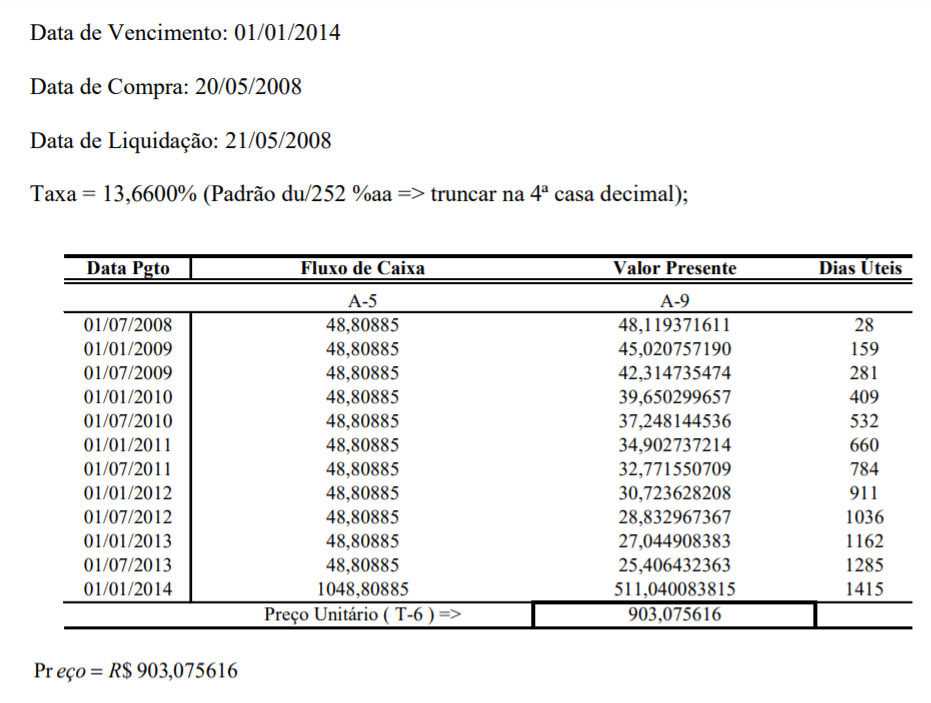

__Teste 2__: NTN-F de hoje (18/02/2022) a 01/01/2031, com TIR = 11,48%.   

https://www.tesourodireto.com.br/titulos/precos-e-taxas.htm

In [46]:
# Definindo as datas e feriados para o "Teste 2"
# dt_ini = dt.date.today().strftime('%d/%m/%Y')
dt_ini = '18/02/2022'
dt_fim = '01/01/2031'
feriados = pd.read_excel('https://www.anbima.com.br/feriados/arqs/feriados_nacionais.xls')

In [47]:
# Teste de prazo anualizado "DC/360"
convencao = 'DC/360'
resposta = calcula_prazo(dt_ini, dt_fim, feriados, convencao)
print(f'Prazo anualizado (dias corridos): {resposta}')

Prazo anualizado (dias corridos): 8.98888888888889


In [48]:
# Teste de prazo anualizado "DU/252"
convencao = 'DU/252'
resposta = calcula_prazo(dt_ini, dt_fim, feriados, convencao)
print(f'Prazo anualizado (dias úteis): {resposta}')

Prazo anualizado (dias úteis): 8.82936507936508


In [49]:
# Teste de prazo em dias "DC"
tipo = 'DC'
resposta = calcula_prazo_dias(dt_ini, dt_fim, feriados, tipo)
print(f'Prazo em dias corridos: {resposta}')

Prazo em dias corridos: 3236


In [50]:
# Teste de prazo em dias "DU"
tipo = 'DU'
resposta = calcula_prazo_dias(dt_ini, dt_fim, feriados, tipo)
print(f'Prazo em dias úteis: {resposta}')

Prazo em dias úteis: 2225


In [51]:
def constroi_fluxo(dt_fim, frequencia):

    # Convertendo a data de string para date
    dt_fim = dt.datetime.strptime(dt_fim, "%d/%m/%Y").date()
    
    # Definindo a data de compra
#     dt_hoje = dt.date.today()
    dt_hoje = '18/02/2022'
    dt_hoje = dt.datetime.strptime(dt_hoje, "%d/%m/%Y").date()
    
    # Criando um laço para pegar as datas de pagamento dos cupons, partindo de "dt_fim" até chegar em "dt_hoje"
    dt_subtrai_fim = dt_fim
    lista_de_datas_dos_fluxos = []
    
    if frequencia == 'anual':
        freq = relativedelta(years=+1)
    elif frequencia == 'semestral':
        freq = relativedelta(months=+6)
    elif frequencia == 'trimestral':
        freq = relativedelta(months=+3)
    elif frequencia == 'mensal':
        freq = relativedelta(months=+1)
    
    while dt_subtrai_fim > dt_hoje:
        lista_de_datas_dos_fluxos.append(dt_subtrai_fim)
        dt_subtrai_fim -= freq
        
    # Ordenando a lista com as datas dos fluxos
    lista_de_datas_dos_fluxos.sort()
    
    return lista_de_datas_dos_fluxos

In [52]:
# Teste de fluxo com frequencia = 'semestral'
frequencia = 'semestral'
resposta = constroi_fluxo(dt_fim, frequencia)
print('Datas dos fluxos com frequência semestral:')
resposta

Datas dos fluxos com frequência semestral:


[datetime.date(2022, 7, 1),
 datetime.date(2023, 1, 1),
 datetime.date(2023, 7, 1),
 datetime.date(2024, 1, 1),
 datetime.date(2024, 7, 1),
 datetime.date(2025, 1, 1),
 datetime.date(2025, 7, 1),
 datetime.date(2026, 1, 1),
 datetime.date(2026, 7, 1),
 datetime.date(2027, 1, 1),
 datetime.date(2027, 7, 1),
 datetime.date(2028, 1, 1),
 datetime.date(2028, 7, 1),
 datetime.date(2029, 1, 1),
 datetime.date(2029, 7, 1),
 datetime.date(2030, 1, 1),
 datetime.date(2030, 7, 1),
 datetime.date(2031, 1, 1)]

In [53]:
# Teste de VF
taxa_anual = 10/100
frequencia = 'semestral'
VN = 1000
lista_fluxo = constroi_fluxo(dt_fim, frequencia)

resposta = valor_futuro(taxa_anual, frequencia, VN, lista_fluxo)
print(f'Valor Futuro: {resposta}')

Valor Futuro: [48.80885, 48.80885, 48.80885, 48.80885, 48.80885, 48.80885, 48.80885, 48.80885, 48.80885, 48.80885, 48.80885, 48.80885, 48.80885, 48.80885, 48.80885, 48.80885, 48.80885, 1048.80885]


In [54]:
# Teste de fator de desconto
taxa_anual = 11.48/100
lista_fluxo = constroi_fluxo(dt_fim, frequencia)

resposta = fator_desconto(taxa_anual, lista_fluxo)
print(f'Fator de desconto: {resposta}')

Fator de desconto: [1.039127331, 1.097626383, 1.157919688, 1.222051838, 1.289179912, 1.363518918, 1.437177766, 1.520706553, 1.602856856, 1.693822113, 1.786094404, 1.887458749, 1.991138041, 2.101418544, 2.216850781, 2.340641718, 2.468150015, 2.610472911]


In [55]:
# Teste de PU (1ª data do fluxo)
dt_pgto = '01/07/2022'

VF = 1000 # Valor de Face = Valor Nominal
prazo_anual = calcula_prazo(dt_ini, dt_pgto, feriados, convencao='DU/252')

taxa_anual = 11.48/100

resposta = calcula_pu(VF, prazo_anual, taxa_anual)
print(f'PU: {resposta}')

PU: 46.971000141


In [56]:
# Teste de PU (última data do fluxo)
dt_pgto = '01/01/2031'

VF = 1000 # Valor de Face = Valor Nominal
prazo_anual = calcula_prazo(dt_ini, dt_pgto, feriados, convencao='DU/252')

taxa_anual = 11.48/100

resposta = calcula_pu(VF, prazo_anual, taxa_anual)
print(f'PU: {resposta}')

PU: 401.769673865


In [57]:
# Teste de taxa anual
dt_fim = '01/07/2022'

prazo_anual = calcula_prazo(dt_ini, dt_fim, feriados, convencao='DU/252')
PU = calcula_pu(VF, prazo_anual, taxa_anual)

resposta = calcula_taxa_anual(PU, prazo_anual, valor_base=100)
print(f'Taxa anual: {resposta}')

Taxa anual: 11.48


In [58]:
# Teste de taxa anual
dt_fim = '31/12/2030'

prazo_anual = calcula_prazo(dt_ini, dt_fim, feriados, convencao='DU/252')
PU = calcula_pu(VF, prazo_anual, taxa_anual)

resposta = calcula_taxa_anual(PU, prazo_anual, valor_base=100)
print(f'Taxa anual: {resposta}')

Taxa anual: 11.48


In [59]:
# Teste 2
# dt_base = dt.date.today().strftime('%d/%m/%Y')
dt_base = '18/02/2022'
dt_venc = '01/01/2031'
tir = 11.48/100

resposta = calcula_pu_ntnf(dt_venc, dt_base, tir)
resposta

   Data do fluxo          VF    DU  Fator de desconto          PU
0     2022-07-01    48.80885    89           1.039127   46.971000
1     2023-01-01    48.80885   216           1.097626   44.467636
2     2023-07-01    48.80885   340           1.157920   42.152189
3     2024-01-01    48.80885   465           1.222052   39.940081
4     2024-07-01    48.80885   589           1.289180   37.860387
5     2025-01-01    48.80885   719           1.363519   35.796240
6     2025-07-01    48.80885   841           1.437178   33.961596
7     2026-01-01    48.80885   972           1.520707   32.096166
8     2026-07-01    48.80885  1094           1.602857   30.451160
9     2027-01-01    48.80885  1222           1.693822   28.815806
10    2027-07-01    48.80885  1345           1.786094   27.327139
11    2028-01-01    48.80885  1473           1.887459   25.859559
12    2028-07-01    48.80885  1597           1.991138   24.513042
13    2029-01-01    48.80885  1722           2.101419   23.226620
14    2029

937.853738

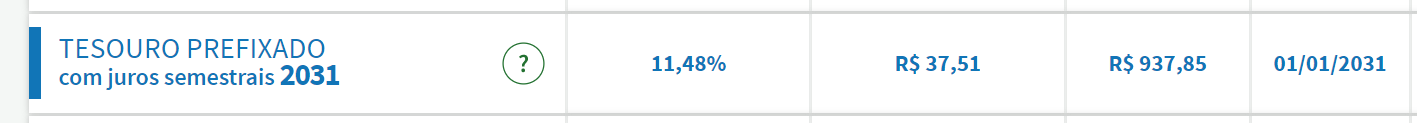